In [1]:
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import ast

In [74]:
df = pd.read_csv('msc_collated_data_20230709.csv')
df.columns

Index(['Unnamed: 0', 'section', 'task_section', 'task', 'trial_id', 'cue_dir',
       'valid_cue', 'key_resp.keys', 'key_resp.rt', 'correct_response',
       'median_left_eye_x', 'mean_left_eye_x', 'participant_number',
       'session_number', 'session_type', 'no_bad_eye_indicies', 'median_aai',
       'mean_aai', 'eyes_open_baseline', 'eyes_closed_baseline',
       'posner_baseline', 'posner_threshold', 'percentage_bad_eye'],
      dtype='object')

 ## Data cleaning

In [27]:
# Selecting columns of interest
df_roi = df[['session_number', 
             'session_type', 
             'participant_number', 
             'key_resp.rt', 
             'task', 
             'valid_cue', 
             'cue_dir', 
             'correct_response',
             'mean_aai']]

# Rename RT column
df_roi.rename(columns={'key_resp.rt':'rt'}, inplace=True)

# Drop nans
df_roi = df_roi.dropna()

# Get first reaction time to usable number
df_roi['rt'] = df_roi['rt'].apply(ast.literal_eval)
df_roi['rt'] = df_roi['rt'].apply(lambda x: x[0])

# Keep only posner tasks
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'baseline0'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'baseline1'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'neurofeedback0'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'neurofeedback1'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'neurofeedback2'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'neurofeedback3'].index)
assert df_roi.task.unique()[0]=='posner0'
assert df_roi.task.unique()[1]=='posner1'
assert len(df_roi.task.unique())==2

# Drop invalid trials
df_roi = df_roi.drop(df_roi[df_roi['valid_cue'] == False].index)
assert df_roi.valid_cue.unique()==True

# Keep only left cues
df_roi = df_roi.drop(df_roi[df_roi['cue_dir'] == 'centre'].index)
df_roi = df_roi.drop(df_roi[df_roi['cue_dir'] == 'right'].index)
assert df_roi.cue_dir.unique()=='left'

# Keep only correct responses:
df_roi = df_roi.drop(df_roi[df_roi['correct_response'] == False].index)
assert df_roi.correct_response.unique()==True

# Just look at session 1 posner a versus session 2 posner b
df_roi = df_roi.drop(df_roi[(df_roi['session_number'] == 'ses-01') & (df_roi['task'] == 'posner1') |
                (df_roi['session_number'] == 'ses-02') & (df_roi['task'] == 'posner0')].index)
# Double check
assert all(df_roi.loc[df_roi['session_number'] == 'ses-01', 'task'] == 'posner0')
assert all(df_roi.loc[df_roi['session_number'] == 'ses-02', 'task'] == 'posner1')

df_roi

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_22549/2057781653.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_roi.rename(columns={'key_resp.rt':'rt'}, inplace=True)


,session_number,session_type,participant_number,rt,task,valid_cue,cue_dir,correct_response,mean_aai,median_aai
4,ses-01,an-at,sub-00,0.340445,posner0,True,left,True,-0.026283,0.059458
5,ses-01,an-at,sub-00,0.346403,posner0,True,left,True,-0.051757,-0.073963
9,ses-01,an-at,sub-00,0.324058,posner0,True,left,True,0.022741,0.015334
10,ses-01,an-at,sub-00,0.382003,posner0,True,left,True,-0.093671,-0.097754
17,ses-01,an-at,sub-00,0.289734,posner0,True,left,True,-0.001150,0.039096
...,...,...,...,...,...,...,...,...,...,...
8556,ses-02,an-at,sub-20,0.282708,posner1,True,left,True,-0.230307,-0.227634
8559,ses-02,an-at,sub-20,0.340457,posner1,True,left,True,0.106847,0.110207
8563,ses-02,an-at,sub-20,0.394256,posner1,True,left,True,-0.001327,0.033392
8564,ses-02,an-at,sub-20,0.400359,posner1,True,left,True,-0.220601,-0.098594


In [35]:
# Function to determine the group of each participant
def set_group(x):
    # print(x.nunique())
    if x.nunique() == 2:
        return 'sham'
    else:
        return 'active'

# Apply the function to each participant
df_roi['group'] = df_roi.groupby('participant_number')['session_type'].transform(set_group)
# print(df_roi.group.count())

### TEST
# df_roi = df_roi.drop(df_roi[df_roi['participant_number'] == 'sub-00'].index)
###

# Rename session_number values for plotting
df_roi['session_number'] = df_roi['session_number'].replace({'ses-01': 'session 1, posner 1', 'ses-02': 'session 2, posner 2'})

df_roi

,session_number,session_type,participant_number,rt,task,valid_cue,cue_dir,correct_response,mean_aai,median_aai,group
4,"session 1, posner 1",an-at,sub-00,0.340445,posner0,True,left,True,-0.026283,0.059458,active
5,"session 1, posner 1",an-at,sub-00,0.346403,posner0,True,left,True,-0.051757,-0.073963,active
9,"session 1, posner 1",an-at,sub-00,0.324058,posner0,True,left,True,0.022741,0.015334,active
10,"session 1, posner 1",an-at,sub-00,0.382003,posner0,True,left,True,-0.093671,-0.097754,active
17,"session 1, posner 1",an-at,sub-00,0.289734,posner0,True,left,True,-0.001150,0.039096,active
...,...,...,...,...,...,...,...,...,...,...,...
8556,"session 2, posner 2",an-at,sub-20,0.282708,posner1,True,left,True,-0.230307,-0.227634,active
8559,"session 2, posner 2",an-at,sub-20,0.340457,posner1,True,left,True,0.106847,0.110207,active
8563,"session 2, posner 2",an-at,sub-20,0.394256,posner1,True,left,True,-0.001327,0.033392,active
8564,"session 2, posner 2",an-at,sub-20,0.400359,posner1,True,left,True,-0.220601,-0.098594,active


## Plot condition and session effect on reaction time

In [66]:
dftmp = df_roi[df_roi["session_number"]=="session 2, posner 2"]
dftmp = dftmp[dftmp["group"]=="sham"]
dftmp.rt.mean()

0.36500804577359103

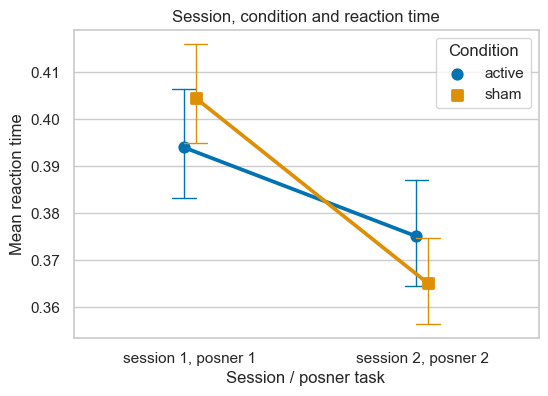

In [68]:
# Interaction plot for session_type and task with respect to key_resp.rt
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
interaction_plot = sns.pointplot(x='session_number', y='rt', hue='group', data=df_roi, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='colorblind')

plt.title('Session, condition and reaction time')
plt.xlabel('Session / posner task')
plt.ylabel('Mean reaction time')
plt.legend(title='Condition')
plt.show()

#### ANOVA for reaction time, session and condition

In [18]:
# Define model
# 'C()' indicates that we want to treat the variables as categorical
pd.set_option('display.float_format', '{:.4f}'.format)
model = ols('rt ~ C(group) + C(session_number) + C(group):C(session_number)', data=df_roi).fit()

# Create anova table with stats
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
pd.reset_option('display.float_format')

                            sum_sq       df       F  PR(>F)
C(group)                    0.0000   1.0000  0.0044  0.9472
C(session_number)           0.1939   1.0000 25.5494  0.0000
C(group):C(session_number)  0.0246   1.0000  3.2438  0.0720
Residual                    7.0723 932.0000     NaN     NaN


## AAI changes?

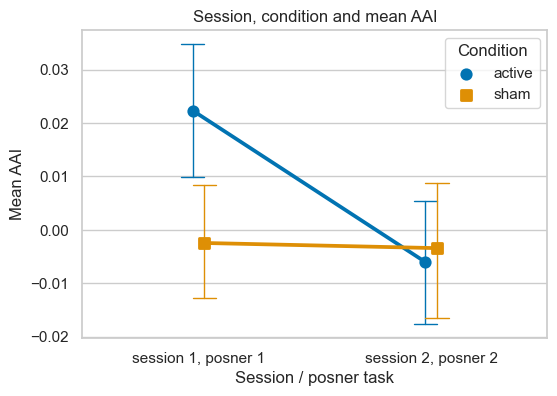

In [69]:
# Interaction plot for session_type and task with respect to key_resp.rt
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
interaction_plot = sns.pointplot(x='session_number', y='mean_aai', hue='group', data=df_roi, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='colorblind')
plt.title('Session, condition and mean AAI')
plt.xlabel('Session / posner task')
plt.ylabel('Mean AAI')
plt.legend(title='Condition')
plt.show()

#### ANOVA for mean AAI, session and condition

In [203]:
# Define model
# 'C()' indicates that we want to treat the variables as categorical
# pd.set_option('display.float_format', '{:.3f}'.format)
model = ols('mean_aai ~ C(group) + C(session_number) + C(group):C(session_number)', data=df_roi).fit()

# Create anova table with stats
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
# pd.reset_option('display.float_format')

                              sum_sq     df         F    PR(>F)
C(group)                    0.029567    1.0  3.469133  0.062839
C(session_number)           0.053831    1.0  6.316031  0.012133
C(group):C(session_number)  0.043741    1.0  5.132199  0.023715
Residual                    7.943305  932.0       NaN       NaN


## Baseline changes in AAI

In [98]:

# Selecting columns of interest
df_base = df[['session_number', 
             'session_type', 
             'participant_number', 
             'task', 
             'mean_aai',
             'median_aai']]

# # Keep only posner tasks
df_base = df_base.drop(df_base[df_base['task'] == 'posner0'].index)
df_base = df_base.drop(df_base[df_base['task'] == 'posner1'].index)
df_base = df_base.drop(df_base[df_base['task'] == 'neurofeedback0'].index)
df_base = df_base.drop(df_base[df_base['task'] == 'neurofeedback1'].index)
df_base = df_base.drop(df_base[df_base['task'] == 'neurofeedback2'].index)
df_base = df_base.drop(df_base[df_base['task'] == 'neurofeedback3'].index)

assert df_base.task.unique()[0]=='baseline0'
assert df_base.task.unique()[1]=='baseline1'
assert len(df_base.task.unique())==2

df_base = df_base.dropna()

# Just look at session 1 posner a versus session 2 posner b
df_base = df_base.drop(df_base[(df_base['session_number'] == 'ses-01') & (df_base['task'] == 'posner1') |
                (df_roi['session_number'] == 'ses-02') & (df_roi['task'] == 'posner0')].index)
# Double check
assert all(df_base.loc[df_base['session_number'] == 'ses-01', 'task'] == 'posner0')
assert all(df_base.loc[df_base['session_number'] == 'ses-02', 'task'] == 'posner1')

# Apply the function to each participant
df_base['group'] = df_base.groupby('participant_number')['session_type'].transform(set_group)

# Rename session_number values for plotting
df_base['session_number'] = df_base['session_number'].replace({'ses-01': 'session', 'ses-02': 'session 2, posner 2'})

df_base

,session_number,session_type,participant_number,task,mean_aai,median_aai,group
0,"session 1, posner 1",an-at,sub-00,baseline0,-0.021448,-0.025365,active
1,"session 1, posner 1",an-at,sub-00,baseline0,-0.118236,-0.118160,active
2,"session 1, posner 1",an-at,sub-00,baseline1,-0.019690,-0.029137,active
3,"session 1, posner 1",an-at,sub-00,baseline1,-0.151139,-0.152321,active
216,"session 2, posner 2",an-at,sub-00,baseline0,-0.003064,0.000668,active
...,...,...,...,...,...,...,...
8157,"session 1, posner 1",an-at,sub-20,baseline1,-0.043189,-0.050904,active
8370,"session 2, posner 2",an-at,sub-20,baseline0,-0.082235,-0.088299,active
8371,"session 2, posner 2",an-at,sub-20,baseline0,-0.129500,-0.138922,active
8372,"session 2, posner 2",an-at,sub-20,baseline1,0.001747,0.004682,active


In [ ]:
# Interaction plot for session_type and task with respect to key_resp.rt
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
interaction_plot = sns.pointplot(x='session_number', y='mean_aai', hue='group', data=df_roi, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='colorblind')
plt.title('Session, condition and mean AAI for baseline recordings')
plt.xlabel('Session / posner task')
plt.ylabel('Mean AAI')
plt.legend(title='Condition')
plt.show()